# Annotate Peaks

Annotate peak features such as GC content, gene features, distances from nearest genes, etc.

In [1]:
library(annotatr)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(patchwork)


Attaching package: ‘patchwork’


The following object is masked from ‘package:annotatr’:

    plot_annotation




In [2]:
BED_DIR = "/oak/stanford/groups/akundaje/surag/GEO/GSE36570/bpnet/"

In [3]:
bed_names = sub(".bed", "", list.files(sprintf("%s/", BED_DIR), pattern="*bed"))
bed_names

[1] "KLF4.idr"      "MYC.idr"       "OCT4.rep1.10k" "SOX2.idr"

In [4]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

In [36]:
get_annotated_df <- function(annotations, bed_names, bed_dir) {
    annotated = list()

    for (i in bed_names) {
        peaks = read.table(sprintf("%s/%s.bed", bed_dir, i))
        colnames(peaks) = c("chr", "start", "end")
        peaks = makeGRangesFromDataFrame(peaks)

        dm_annotated = annotate_regions(
        regions = peaks,
        annotations = annotations,
        ignore.strand = TRUE,
        quiet = TRUE)

        dm_annsum = summarize_annotations(
        annotated_regions = dm_annotated,
        quiet = TRUE)

        annotated[[i]] = dm_annsum
        }
    
    # specific to type of annotation, this one for gene level annotation
    annotated_df = data.frame(annotated[[1]])
    annotated_df = annotated_df[order(annotated_df$annot.type), ] # sort by rowname for ease
    rownames(annotated_df) = annotated_df$annot.type
    annotated_df$annot.type = NULL
    colnames(annotated_df) = bed_names[1]

    for (i in bed_names[2:length(bed_names)]) {
        cur_df = annotated[[i]]
        rownames(cur_df) = cur_df$annot.type
        annotated_df[, sprintf("%s", i)] = cur_df[rownames(annotated_df), "n"]
    }
    
    # replace NA with 0
    annotated_df[is.na(annotated_df)] = 0
    
    # get percentage
    annotated_df = 100*t(t(annotated_df)/colSums(annotated_df))

    annotated_df
}

## Genes

In [37]:
annotations = build_annotations(genome = 'hg38', annotations = c('hg38_basicgenes', 
                                                                 'hg38_genes_intergenic',
                                                                 'hg38_genes_intronexonboundaries'))

'select()' returned 1:1 mapping between keys and columns

Building promoters...

Building 1to5kb upstream of TSS...

Building intergenic...

Building 5UTRs...

Building 3UTRs...

Building exons...

Building introns...

Building intron exon boundaries...

Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
"GRanges object contains 131 out-of-bound ranges located on sequences
  chr1_GL383518v1_alt, chr2_GL383522v1_alt, chr5_GL339449v2_alt,
  chr5_KI270795v1_alt, chr5_KI270898v1_alt, chr6_KI270797v1_alt,
  chr6_KI270798v1_alt, chr6_KI270801v1_alt, chr7_GL383534v2_alt,
  chr7_KI270803v1_alt, chr7_KI270806v1_alt, chr7_KI270809v1_alt,
  chr8_KI270821v1_alt, chr9_GL383540v1_alt, chr9_GL383541v1_alt,
  chr11_KI270902v1_alt, chr12_GL383551v1_alt, chr12_GL383553v2_alt,
  chr12_KI270834v1_alt, chr14_KI270847v1_alt, chr15_KI270850v1_alt,
  chr16_KI270854v1_alt, chr17_JH159146v1_alt, chr17_JH159147v1_alt,
  chr17_KI270857v1_alt, chr17_KI270860v1_alt, chr19_GL383575v2_alt,
  chr1

In [38]:
genic_annotated_df = get_annotated_df(annotations, bed_names, BED_DIR)

Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."


In [40]:
genic_annotated_df

,KLF4.idr,MYC.idr,OCT4.rep1.10k,SOX2.idr
hg38_genes_1to5kb,13.494232,13.001728,11.256952,9.9400023
hg38_genes_3UTRs,1.953046,1.206696,1.668521,2.9710396
hg38_genes_5UTRs,5.343048,9.628077,1.668521,0.5134418
hg38_genes_exons,10.964380,14.426536,5.806452,6.5362871
hg38_genes_intergenic,15.113337,8.412883,22.684464,21.6337833
hg38_genes_intronexonboundaries,8.930378,11.101040,5.094549,5.4863274
hg38_genes_introns,33.156244,26.836246,46.629588,50.0519211
hg38_genes_promoters,11.045335,15.386794,5.190953,2.8671974


In [41]:
# rename rows
rownames(genic_annotated_df) = lapply(strsplit(rownames(genic_annotated_df), "_"), "[[", 3)

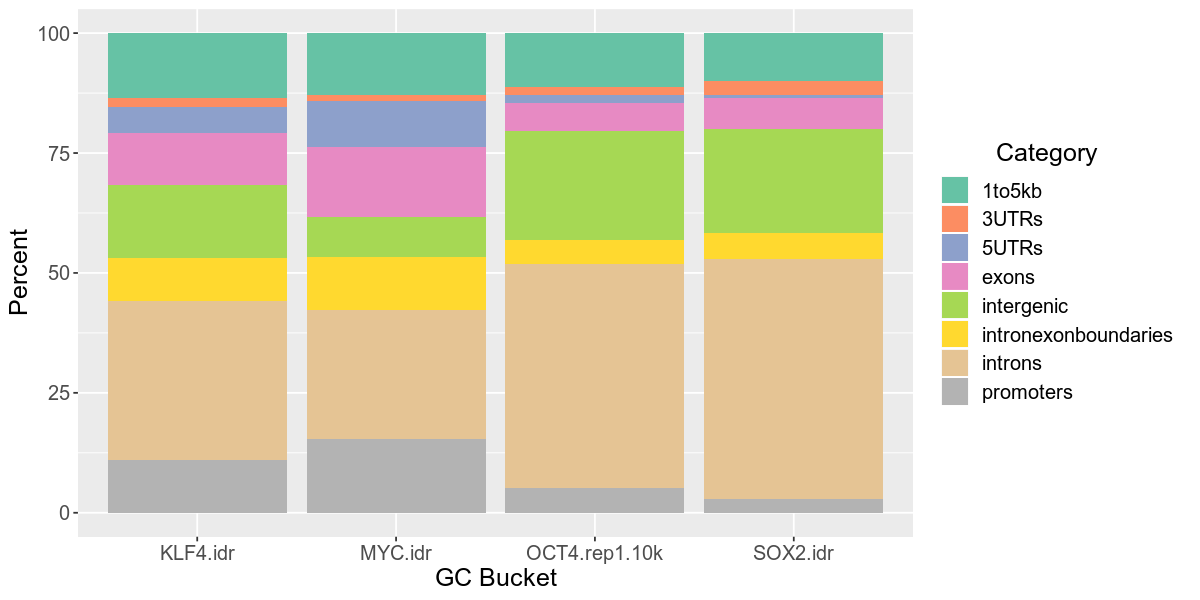

In [42]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=melt(genic_annotated_df), aes(x=factor(Var2, levels=colnames(genic_annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_brewer(palette="Set2") +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## CpG

In [43]:
annotations = build_annotations(genome = 'hg38', annotations = c('hg38_cpgs'))

Building CpG islands...

Building CpG shores...

Building CpG shelves...

Building inter-CpG-islands...



In [44]:
cpg_annotated_df = get_annotated_df(annotations, bed_names, BED_DIR)

Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrUn_GL000195v1, chrUn_KI270754v1
  - in 'y': chr10_GL383545v1_alt, chr10_GL383546v1_alt, chr10_KI270824v1_alt, chr10_KI270825v1_alt, chr11_KI270721v1_random, chr11_KI270826v1_alt, chr11_KI270830v1_alt, chr11_KI270831v1_alt, chr11_KI270832v1_alt, chr11_KI270902v1_alt, chr11_KI270903v1_alt, chr11_KI270927v1_alt, chr12_GL383550v2_alt, chr12_GL383553v2_alt, chr12_GL877875v1_alt, chr12_GL877876v1_alt, chr12_KI270833v1_alt, chr12_KI270834v1_alt, chr12_KI270835v1_alt, chr12_KI270836v1_alt, chr12_KI270904v1_alt, chr13_KI270838v1_alt, chr13_KI270840v1_alt, chr13_KI270842v1_alt, chr14_GL000009v2_random, chr14_GL000194v1_random, chr14_GL000225v1_random, chr14_KI270722v1_random, chr14_KI270723v1_random, chr14_KI270724v1_random, chr14_KI270725v1_random, chr14_KI270726v1_random, chr14_KI270844v1_alt, chr14_KI270845v1_alt, chr14_KI270846v1_alt, chr14_KI270847v1_alt, chr15_GL3

In [45]:
cpg_annotated_df

,KLF4.idr,MYC.idr,OCT4.rep1.10k,SOX2.idr
hg38_cpg_inter,63.336680,44.193188,87.471861,93.689431515
hg38_cpg_islands,13.930723,28.112786,1.967309,0.007630675
hg38_cpg_shelves,5.814926,3.193747,4.453362,3.540633346
hg38_cpg_shores,16.917671,24.500279,6.107468,2.762304464


In [47]:
# rename rows
rownames(cpg_annotated_df) = lapply(strsplit(rownames(cpg_annotated_df), "_"), "[[", 3)

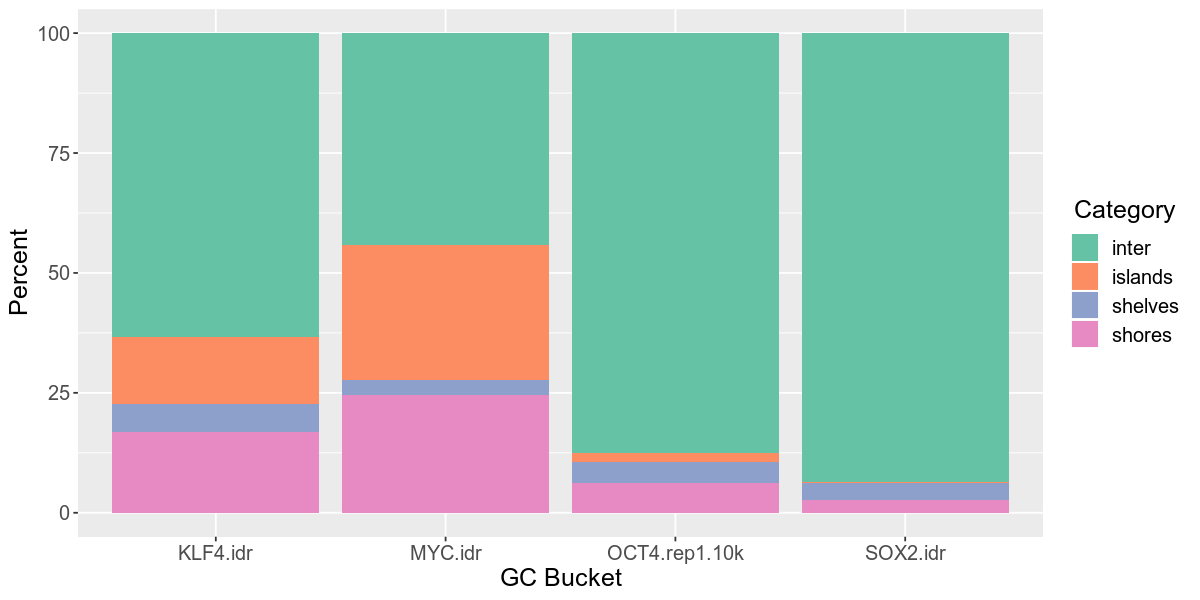

In [48]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=melt(cpg_annotated_df), aes(x=factor(Var2, levels=colnames(cpg_annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_brewer(palette="Set2") +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## Distance From Nearest Gene

In [17]:
library(EnsDb.Hsapiens.v86)

Loading required package: ensembldb

Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter




In [18]:
edb <- EnsDb.Hsapiens.v86

In [19]:
genes.hg38 = genes(edb, column = "gene_name", filter = GeneBiotypeFilter("protein_coding"))

In [20]:
tss.hg38 = resize(genes.hg38, width=1, fix='start')
head(tss.hg38, 2)

GRanges object with 2 ranges and 3 metadata columns:
                  seqnames    ranges strand |   gene_name         gene_id
                     <Rle> <IRanges>  <Rle> | <character>     <character>
  ENSG00000186092        1     69091      + |       OR4F5 ENSG00000186092
  ENSG00000279928        1    182393      + |  FO538757.2 ENSG00000279928
                    gene_biotype
                     <character>
  ENSG00000186092 protein_coding
  ENSG00000279928 protein_coding
  -------
  seqinfo: 287 sequences from GRCh38 genome

In [21]:
plots = list()

for (i in bed_names) {
    # take mid of peaks
    peaks = read.table(sprintf("%s/%s.bed", BED_DIR, i))
    colnames(peaks) = c("chr", "start", "end")
    peaks$chr = sub("chr", "", peaks$chr)
    peaks_mid = as.integer((peaks$start+peaks$end)/2)
    peaks$start = peaks_mid
    peaks$end = peaks_mid+1
    peaks = makeGRangesFromDataFrame(peaks)
    
    dists = data.frame(distanceToNearest(peaks, tss.hg38, ignore.strand=TRUE))$distance
    print(median(dists))
    plots[[i]] <- ggplot(data.frame(d=dists+1), aes(x=d)) + 
        geom_histogram(bins=50, col='black', alpha=0.5, fill='red') +
        scale_x_log10() +
        coord_cartesian(xlim=c(1,1e7)) +
        ggtitle(sprintf("%s", i)) +  
        xlab("Distance from Nearest TSS") + ylab("Count") + 
        geom_vline(xintercept = 1000, linetype="dashed") +
        theme(plot.title = element_text(hjust = 0.5))
}

[1] 30151.5
[1] 15483


Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': Un_GL000195v1, Un_GL000219v1, Un_KI270754v1
  - in 'y': CHR_HG107_PATCH, CHR_HG126_PATCH, CHR_HG1311_PATCH, CHR_HG1342_HG2282_PATCH, CHR_HG1362_PATCH, CHR_HG142_HG150_NOVEL_TEST, CHR_HG151_NOVEL_TEST, CHR_HG1832_PATCH, CHR_HG2021_PATCH, CHR_HG2023_PATCH, CHR_HG2030_PATCH, CHR_HG2058_PATCH, CHR_HG2063_PATCH, CHR_HG2066_PATCH, CHR_HG2072_PATCH, CHR_HG2095_PATCH, CHR_HG2104_PATCH, CHR_HG2116_PATCH, CHR_HG2191_PATCH, CHR_HG2213_PATCH, CHR_HG2217_PATCH, CHR_HG2232_PATCH, CHR_HG2233_PATCH, CHR_HG2235_PATCH, CHR_HG2239_PATCH, CHR_HG2247_PATCH, CHR_HG2288_HG2289_PATCH, CHR_HG2290_PATCH, CHR_HG2291_PATCH, CHR_HG2334_PATCH, CHR_HG26_PATCH, CHR_HG986_PATCH, CHR_HSCHR10_1_CTG1, CHR_HSCHR10_1_CTG2, CHR_HSCHR10_1_CTG4, CHR_HSCHR11_1_CTG1_2, CHR_HSCHR11_1_CTG5, CHR_HSCHR11_1_CTG6, CHR_HSCHR11_1_CTG7, CHR_HSCHR11_1_CTG8, CHR_HSCHR11_2_CTG1, CHR_HSCHR11_2_CTG1_1, CHR_HSCHR11_3_CT

[1] 60075
[1] 67037


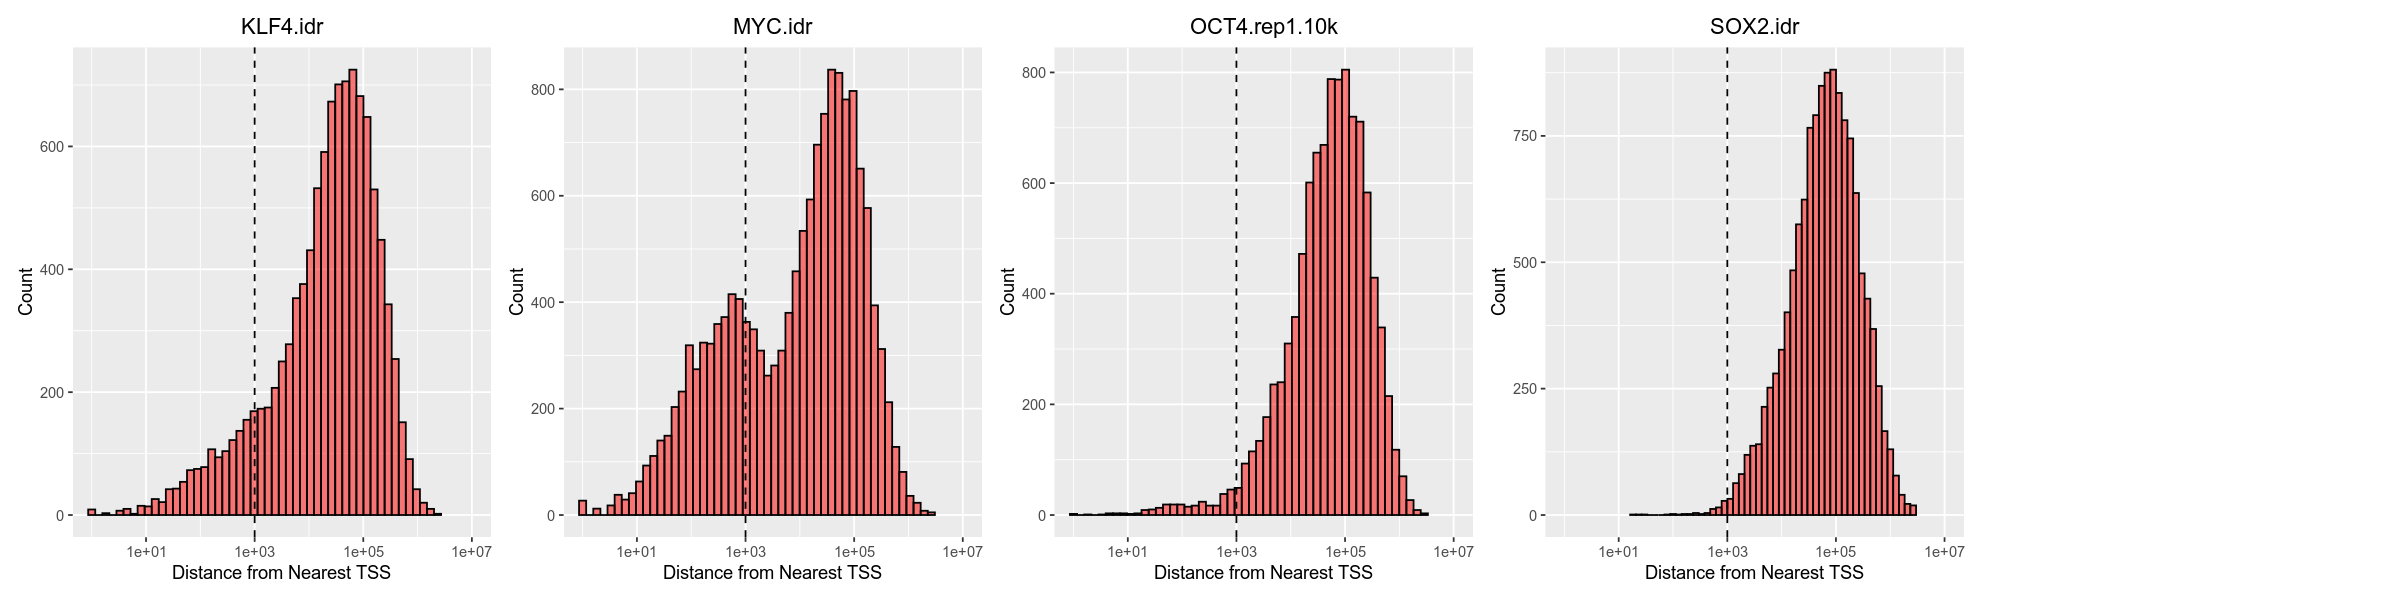

In [22]:
options(repr.plot.width = 20, repr.plot.height = 5)
wrap_plots(plots, ncol = 5)

## ChromHMM - Fibroblast

In [49]:
gzf = gzfile("/users/surag/kundajelab/scATAC-reprog/resources/ChromHMM/E055_15_coreMarks_hg38lift_mnemonics.bed.gz")
gr = read.table(gzf)
colnames(gr) = c("chr", "start", "end", "type")
annotations = makeGRangesFromDataFrame(gr)
annotations$type = gr$type
annotations

GRanges object with 671383 ranges and 1 metadata column:
           seqnames            ranges strand |        type
              <Rle>         <IRanges>  <Rle> |    <factor>
       [1]     chr1       10000-10800      * |       9_Het
       [2]     chr1       10800-12600      * |    15_Quies
       [3]     chr1       12600-18400      * |      5_TxWk
       [4]     chr1       18400-88600      * |    15_Quies
       [5]     chr1       88600-90600      * | 14_ReprPCWk
       ...      ...               ...    ... .         ...
  [671379]     chrY 56887453-57217249      * |    15_Quies
  [671380]     chrM           0-12799      * |    15_Quies
  [671381]     chrM       12799-12999      * |       9_Het
  [671382]     chrM       12999-13199      * |  8_ZNF/Rpts
  [671383]     chrM       13199-16398      * |      5_TxWk
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [50]:
fib_annotated_df = get_annotated_df(annotations, bed_names, BED_DIR)

Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrUn_GL000195v1, chrUn_GL000219v1, chrUn_KI270754v1
  - in 'y': chrM
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."


In [51]:
fib_annotated_df

,KLF4.idr,MYC.idr,OCT4.rep1.10k,SOX2.idr
1_TssA,11.6690724,28.2681564,4.1685383,1.96369287
10_TssBiv,1.1775431,2.3304070,0.1527266,0.01412729
11_BivFlnk,2.5678037,3.0486832,0.2335819,0.00000000
12_EnhBiv,2.6209831,1.5429636,0.5839547,0.03531822
13_ReprPC,7.3311555,1.5802075,3.5935675,0.49445504
14_ReprPCWk,12.4211806,3.8254855,11.1759950,7.47333475
15_Quies,15.3308516,6.6400638,31.4437157,45.19319065
2_TssAFlnk,10.5371116,21.5270019,4.3122810,1.51868334
3_TxFlnk,3.5934058,3.8042032,0.7007457,0.11301829
4_Tx,4.2087670,0.9044959,4.2853293,3.63071272


In [52]:
# rename rows
rownames(fib_annotated_df) = lapply(strsplit(rownames(fib_annotated_df), "_"), "[[", 2)

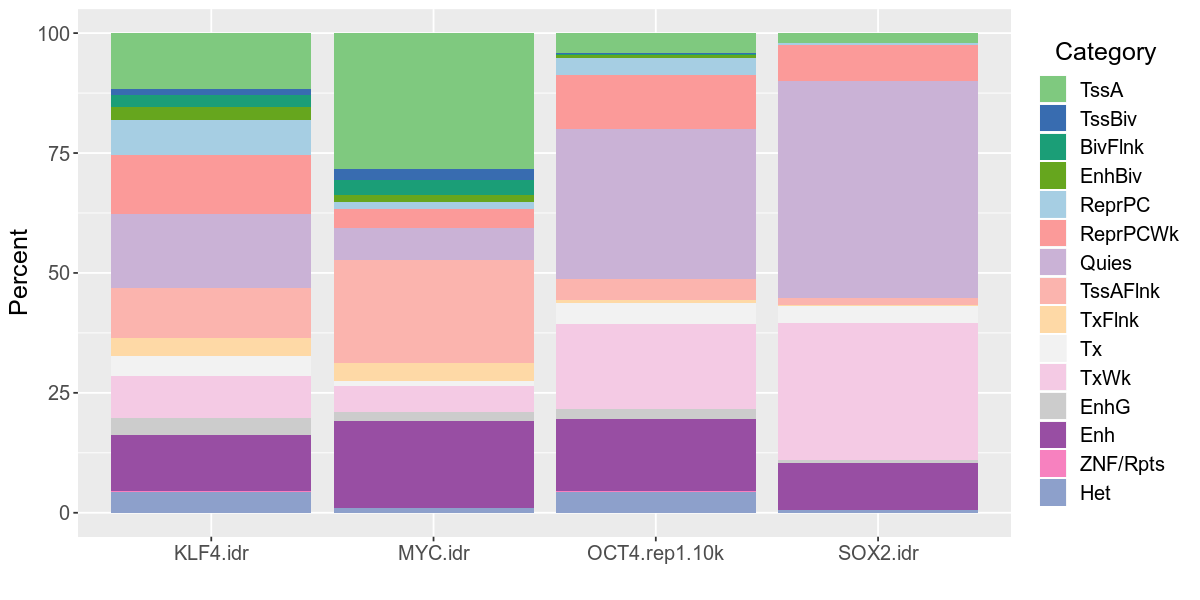

In [61]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=melt(fib_annotated_df), aes(x=factor(Var2, levels=colnames(fib_annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_manual(values=col_vector[seq(1,length(col_vector),4)]) +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))

## ChromHMM - ESC

In [55]:
gzf = gzfile("/users/surag/kundajelab/scATAC-reprog/resources/ChromHMM/E003_15_coreMarks_hg38lift_mnemonics.bed.gz")
gr = read.table(gzf)
colnames(gr) = c("chr", "start", "end", "type")
annotations = makeGRangesFromDataFrame(gr)
annotations$type = gr$type

In [56]:
h1_annotated_df = get_annotated_df(annotations, bed_names, BED_DIR)

Warning message in .Seqinfo.mergexy(x, y):
"Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrUn_GL000195v1, chrUn_GL000219v1, chrUn_KI270754v1
  - in 'y': chrM
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning)."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."
Warning message:
"Setting row names on a tibble is deprecated."


In [57]:
h1_annotated_df

,KLF4.idr,MYC.idr,OCT4.rep1.10k,SOX2.idr
1_TssA,13.1390311,27.8916915,3.1961793,1.09954125
10_TssBiv,2.3158724,4.5278355,0.4408523,0.01456346
11_BivFlnk,2.1268216,4.3312173,0.4775900,0.05825384
12_EnhBiv,2.0559275,2.2863884,0.8082292,0.22573363
13_ReprPC,1.9062623,1.4830627,1.3041881,0.56797495
14_ReprPCWk,4.8759354,3.2189203,3.7839824,1.73305177
15_Quies,35.6045687,24.4873883,54.4636297,64.39962135
2_TssAFlnk,3.8912958,5.9153980,1.0929464,0.26214229
3_TxFlnk,0.2441906,0.5224426,0.1469508,0.05097211
4_Tx,3.6786136,2.0167406,4.1513593,4.82778708


In [58]:
# rename rows
rownames(h1_annotated_df) = lapply(strsplit(rownames(h1_annotated_df), "_"), "[[", 2)

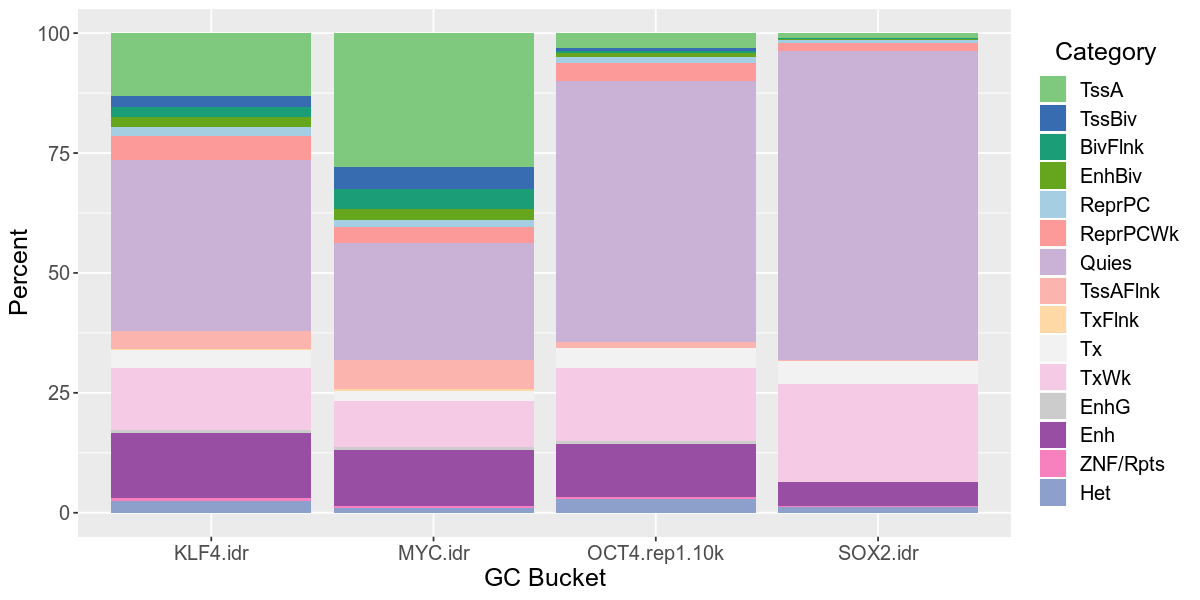

In [59]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(data=melt(h1_annotated_df), aes(x=factor(Var2, levels=colnames(h1_annotated_df)),
                                    y=value, fill=Var1)) +
scale_fill_manual(values=col_vector[seq(1,length(col_vector),4)]) +
geom_bar(stat="identity") +
ylab("Percent") +
xlab("GC Bucket") +
guides(fill = guide_legend(ncol=1, title="Category", pos="center")) +
theme(legend.title.align=0.4,
      text=element_text(size=15))